# x3DH

source : https://signal.org/docs/specifications/doubleratchet/doubleratchet.pdf
lib : https://cryptography.io/en/latest/

In [1]:
# Pour fonction de hachage
from cryptography.hazmat.primitives import hashes, hmac
import os
# Pour courbe elliptique
from cryptography.hazmat.primitives.asymmetric import x25519
from cryptography.hazmat.primitives.asymmetric import ed25519
from cryptography.hazmat.primitives import serialization
from cryptography.exceptions import InvalidSignature
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives import padding

from nacl import bindings

In [2]:
HashFunction = hashes.SHA256()
curveSign = ed25519
curveExchange = x25519
info = "Myprotocol"
numberOPKB = 5

In [3]:

#encoder des clés en bytes

def encode_public(key):
    bytes = key.public_bytes(
        encoding=serialization.Encoding.Raw,
        format=serialization.PublicFormat.Raw
    )
    return bytes

def encode_private(key):
    bytes = key.private_bytes(
        encoding=serialization.Encoding.Raw,
        format=serialization.PrivateFormat.Raw,
        encryption_algorithm=serialization.NoEncryption()
    )
    return bytes

# Fonction qui transforme une courbe elliptique de type ed privé en X privé
def ed_priv_to_X(ed_priv: ed25519.Ed25519PrivateKey):
    seed = ed_priv.private_bytes(
        encoding=serialization.Encoding.Raw,
        format=serialization.PrivateFormat.Raw,
        encryption_algorithm=serialization.NoEncryption()
    )
    pub = ed_priv.public_key().public_bytes(
        encoding=serialization.Encoding.Raw,
        format=serialization.PublicFormat.Raw
    )
    sk_64 = seed + pub
    x_bytes = bindings.crypto_sign_ed25519_sk_to_curve25519(sk_64)
    return x25519.X25519PrivateKey.from_private_bytes(x_bytes)

# Fonctions qui transforme une courbe elliptique de type ed pub en X pub
def ed_pub_to_X(ed_pub: ed25519.Ed25519PublicKey):
    pub_bytes = ed_pub.public_bytes(
        encoding=serialization.Encoding.Raw,
        format=serialization.PublicFormat.Raw
    )
    x_bytes = bindings.crypto_sign_ed25519_pk_to_curve25519(pub_bytes)
    return x25519.X25519PublicKey.from_public_bytes(x_bytes)

class Alice():
    def __init__(self):
        self.__SK = None
        self.__PRIVATE_IKA = None
        self.PUBLIC_IKA = None
        self.__PRIVATE_EKA = None
        self.PUBLIC_EKA = None
        self.Bob_parameters = None
        self.BOB_PUBLIC_IKB = None
        self.BOB_PUBLIC_SPKB = None
        self.BOB_SIGN_SPKB = None
        self.BOB_PUBLIC_OPKB = None
        self.__AD = None
        self.canSendToBob = False

    def get_sk(self):
        return self.__SK

    def generation_general(self):
        # PRIVATE_IKA Alice’s identity key (long-term identity public key)
        self.__PRIVATE_IKA = curveSign.Ed25519PrivateKey.generate()
        # PUBLIC Alice’s identity key (long-term identity public key)
        self.PUBLIC_IKA = self.__PRIVATE_IKA.public_key()
    
    def EKA_renew(self):
        # During each protocol run, Alice generates a new ephemeral key pair with public key EKA.
        #EKA Alice’s ephemeral key
        self.__PRIVATE_EKA = curveExchange.X25519PrivateKey.generate()
        self.PUBLIC_EKA = self.__PRIVATE_EKA.public_key()
    
    def reception_Bob_parameters(self,values):
        tmp = values
        self.BOB_PUBLIC_IKB = tmp['PUBLIC_IKB']
        self.BOB_PUBLIC_SPKB = tmp['PUBLIC_SPKB']
        self.BOB_SIGN_SPKB = tmp['SIGN_SPKB']
        self.BOB_PUBLIC_OPKB = tmp['PUBLIC_OPKB']

        # Alice verifies the prekey signature and aborts the protocol if verification fails.
        public_bytes = self.BOB_PUBLIC_SPKB.public_bytes(
            encoding=serialization.Encoding.Raw,
            format=serialization.PublicFormat.Raw)
        try:
            # Leve une exception si problème
            verification = self.BOB_PUBLIC_IKB.verify(self.BOB_SIGN_SPKB,public_bytes)

            # Alice then generates an ephemeral key pair with public key EKA.
            self.EKA_renew()

            if self.BOB_PUBLIC_OPKB == None:

                # DH1 = DH(IKA, SPKB)
                key = ed_priv_to_X(self.__PRIVATE_IKA)
                DH1 = key.exchange(self.BOB_PUBLIC_SPKB)
                # DH2 = DH(EKA, IKB)
                key = ed_pub_to_X(self.BOB_PUBLIC_IKB)
                DH2 = self.__PRIVATE_EKA.exchange(key)
                # DH3 = DH(EKA, SPKB)
                DH3 = self.__PRIVATE_EKA.exchange(self.BOB_PUBLIC_SPKB)
                # SK = KDF(DH1 || DH2 || DH3)
                self.__SK = HKDF(
                    algorithm=hashes.SHA256(),
                    length=32,
                    salt=None,
                    info=b'test',
                ).derive(DH1+DH2+DH3)

                # After calculating SK, Alice deletes her ephemeral private key and the DH outputs.
                self.__PRIVATE_EKA = None
                DH1 = DH2 = DH3 = None

                # Alice then calculates an “associated data” byte sequence AD that contains
                # identity information for both parties:
                # AD = Encode(IKA) || Encode(IKB)

#                 (ATTENTION) :  Alice may optionally append additional information to AD, such as Alice and
# Bob’s usernames, certificates, or other identifying information.

                self.__AD = encode_public(self.PUBLIC_IKA) + encode_public(self.BOB_PUBLIC_IKB)
                
                # Alice then sends Bob an initial message :

                data = b'test first message to Bob'
                aesgcm = AESGCM(self.__SK)
                nonce = os.urandom(12)
                c = aesgcm.encrypt(nonce, data, self.__AD)
                

                first_message=[self.PUBLIC_IKA,self.PUBLIC_EKA,-1,c,nonce]
                self.canSendToBob = True

            else:
                 # DH1 = DH(IKA, SPKB)
                key = ed_priv_to_X(self.__PRIVATE_IKA)
                DH1 = key.exchange(self.BOB_PUBLIC_SPKB)
                # DH2 = DH(EKA, IKB)
                key = ed_pub_to_X(self.BOB_PUBLIC_IKB)
                DH2 = self.__PRIVATE_EKA.exchange(key)
                # DH3 = DH(EKA, SPKB)
                DH3 = self.__PRIVATE_EKA.exchange(self.BOB_PUBLIC_SPKB)
                # DH4 = DH(EKA, OPKB)
                DH4 = self.__PRIVATE_EKA.exchange(self.BOB_PUBLIC_OPKB[0])

                self.__SK = HKDF(
                    algorithm=hashes.SHA256(),
                    length=32,
                    salt=None,
                    info=b'test',
                ).derive(DH1+DH2+DH3+DH4)


                # After calculating SK, Alice deletes her ephemeral private key and the DH outputs.
                self.__PRIVATE_EKA = None
                # self.PUBLIC_EKA = None
                DH1 = DH2 = DH3 = DH4 = None


                # Alice then calculates an “associated data” byte sequence AD that contains
                # identity information for both parties:
                # AD = Encode(IKA) || Encode(IKB)

#                 (ATTENTION) :  Alice may optionally append additional information to AD, such as Alice and
# Bob’s usernames, certificates, or other identifying information.

                self.__AD = encode_public(self.PUBLIC_IKA) + encode_public(self.BOB_PUBLIC_IKB)
                
                
                # Alice then sends Bob an initial message :

                data = b'test first message to Bob'
                aesgcm = AESGCM(self.__SK)
                nonce = os.urandom(12)
                c = aesgcm.encrypt(nonce, data, self.__AD)
                
                
                first_message=[self.PUBLIC_IKA,self.PUBLIC_EKA,self.BOB_PUBLIC_OPKB[1],c,nonce]
                self.canSendToBob = True



        except InvalidSignature as e:
            first_message = None
            print("Signature invalide")

        return first_message


def sendToBob(message):
    
    return None

class Bob():

    def __init__(self):
        self.__SK = None
        self.__PRIVATE_IKB = None
        self.__PUBLIC_IKB = None
        self.__PRIVATE_SPKB = None
        self.__PUBLIC_SPKB = None
        self.__SIGN_SPKB = None
        self.__PUBLIC_OPKB_pairs = []
        self.__PRIVATE_OPKB_pairs = []
        self.ALICE_PUBLIC_IKA = None
        self.ALICE_PUBLIC_EKA = None

    def get_sk(self):
        return self.__SK

    def generation_general(self):
        # PRIVATE_IKB Bob’s identity key (long-term identity public key)
        self.__PRIVATE_IKB = curveSign.Ed25519PrivateKey.generate()
        # PUBLIC IKB Bob’s identity key (long-term identity public key)
        self.__PUBLIC_IKB = self.__PRIVATE_IKB.public_key()

        # (ATTENTION) A CHANGER PERIODIQUEMENT : pas fait
        #################

        # PRIVATE SPKB Bob’s signed prekey
        self.__PRIVATE_SPKB = curveExchange.X25519PrivateKey.generate()
        # PUBLIC SPKB Bob’s signed prekey
        self.__PUBLIC_SPKB = self.__PRIVATE_SPKB.public_key()

        #################

        # SIGNATURE of SPKB Bob’s signed prekey
        public_bytes = self.__PUBLIC_SPKB.public_bytes(
            encoding=serialization.Encoding.Raw,
            format=serialization.PublicFormat.Raw)
        self.__SIGN_SPKB = self.__PRIVATE_IKB.sign(public_bytes)

        # OPKB Bob’s one-time prekey
        cpt = 0
        for i in range(numberOPKB):
            PRIVATE_OPKB = curveExchange.X25519PrivateKey.generate()
            PUBLIC_OPKB = PRIVATE_OPKB.public_key()
            self.__PUBLIC_OPKB_pairs.append([PUBLIC_OPKB,cpt])
            self.__PRIVATE_OPKB_pairs.append([PRIVATE_OPKB,cpt])
            cpt = cpt + 1

    def send_bob_parameters(self):

        return {
            "PUBLIC_IKB": self.__PUBLIC_IKB,
            "PUBLIC_SPKB": self.__PUBLIC_SPKB,
            "SIGN_SPKB": self.__SIGN_SPKB,
            "PUBLIC_OPKB_pairs": self.__PUBLIC_OPKB_pairs
        }

    def messagefromAlice(self,message):
        self.ALICE_PUBLIC_IKA = message[0]
        self.ALICE_PUBLIC_EKA = message[1]
        BOB_PUBLIC_OPKB_ID = message[2]
        c = message[3]
        nonce = message[4]

        # Using these keys, Bob repeats the DH and KDF calculations from the previous
        # section to derive SK, and then deletes the DH values.

        if(BOB_PUBLIC_OPKB_ID == -1):
            
            # DH1 = DH(IKA, SPKB)
            key = ed_pub_to_X(self.ALICE_PUBLIC_IKA)
            DH1 = self.__PRIVATE_SPKB.exchange(key)
            # DH2 = DH(EKA, IKB)
            key = ed_priv_to_X(self.__PRIVATE_IKB)
            DH2 = key.exchange(self.ALICE_PUBLIC_EKA)
            # DH3 = DH(EKA, SPKB)
            DH3 = self.__PRIVATE_SPKB.exchange(self.ALICE_PUBLIC_EKA)


            self.__SK = HKDF(
                algorithm=hashes.SHA256(),
                length=32,
                salt=None,
                info=b'test',
            ).derive(DH1+DH2+DH3)


            # After calculating SK, Alice deletes her ephemeral private key and the DH outputs.
            DH1 = DH2 = DH3 = None

            self.AD = encode_public(self.ALICE_PUBLIC_IKA) + encode_public(self.__PUBLIC_IKB)


            aesgcm = AESGCM(self.__SK)
            message = aesgcm.decrypt(nonce, c, self.AD)
            print(message)
        else:
            # DH1 = DH(IKA, SPKB)
            key = ed_pub_to_X(self.ALICE_PUBLIC_IKA)
            DH1 = self.__PRIVATE_SPKB.exchange(key)
            # DH2 = DH(EKA, IKB)
            key = ed_priv_to_X(self.__PRIVATE_IKB)
            DH2 = key.exchange(self.ALICE_PUBLIC_EKA)
            # DH3 = DH(EKA, SPKB)
            DH3 = self.__PRIVATE_SPKB.exchange(self.ALICE_PUBLIC_EKA)
            # DH4 = DH(EKA, OPKB)
            for i in self.__PRIVATE_OPKB_pairs:
                if i[1] == BOB_PUBLIC_OPKB_ID:
                    key3 = i[0]
                    break
            DH4 = key3.exchange(self.ALICE_PUBLIC_EKA)


            self.__SK = HKDF(
                algorithm=hashes.SHA256(),
                length=32,
                salt=None,
                info=b'test',
            ).derive(DH1+DH2+DH3+DH4)


            # After calculating SK, Alice deletes her ephemeral private key and the DH outputs.
            DH1 = DH2 = DH3 = DH4 = None

            self.AD = encode_public(self.ALICE_PUBLIC_IKA) + encode_public(self.__PUBLIC_IKB)

            aesgcm = AESGCM(self.__SK)
            message = aesgcm.decrypt(nonce, c, self.AD)
            return message



class serveur():

    def __init__(self):
        self.BOB_PUBLIC_IKB = None,
        self.BOB_PUBLIC_SPKB = None,
        self.BOB_SIGN_SPKB = None,
        self.BOB_PUBLIC_OPKB_pairs = [],
        self.initialmessage = None
    
    def reception_Bob_parameters(self,values):
        tmp = values
        self.BOB_PUBLIC_IKB = tmp['PUBLIC_IKB']
        self.BOB_PUBLIC_SPKB = tmp['PUBLIC_SPKB']
        self.BOB_SIGN_SPKB = tmp['SIGN_SPKB']
        self.BOB_PUBLIC_OPKB_pairs = tmp['PUBLIC_OPKB_pairs']
    
    def send_bob_parameters(self):
        if self.BOB_PUBLIC_OPKB_pairs:
            val = self.BOB_PUBLIC_OPKB_pairs.pop(0)  # retourne et supprime le premier
        else:
            val = None
        return {
            "PUBLIC_IKB": self.BOB_PUBLIC_IKB,
            "PUBLIC_SPKB": self.BOB_PUBLIC_SPKB,
            "SIGN_SPKB": self.BOB_SIGN_SPKB,
            "PUBLIC_OPKB": val
        }
    def setInitialmessageAlice(self,m):
        self.initialmessage = m

    def getInitialmessageAlice(self):
        return self.initialmessage
    
def X3DH(params): #algorithm has three phases:
    # 1. Bob publishes his identity key and prekeys to a server.

    # Generation from Bob
    User_Bob = Bob()
    User_Bob.generation_general()
    parameters_from_bob = User_Bob.send_bob_parameters()
    # Reception by serveur
    User_serveur = serveur()
    User_serveur.reception_Bob_parameters(parameters_from_bob)
    if(params):{ print(parameters_from_bob)}

    # 2. Alice fetches a “prekey bundle” from the server, and uses it to send an
    # initial message to Bob.
    User_Alice = Alice()
    User_Alice.generation_general()
    first_message = User_Alice.reception_Bob_parameters(User_serveur.send_bob_parameters())
    User_serveur.setInitialmessageAlice(first_message)
    
    # 3. Bob receives and processes Alice’s initial message.
    message = User_Bob.messagefromAlice(User_serveur.getInitialmessageAlice())
    print(message)

    return User_Alice.get_sk()

SK = X3DH(0)


b'test first message to Bob'


# DoubleRatchetAlgorithm

In [4]:
#Returns a new Diffie-Hellman key pair.
def GENERATE_DH(): 
    # This function is recommended to generate a key pair based on the Curve25519 or Curve448 elliptic curves [12].
    private_key = curveExchange.X25519PrivateKey.generate()
    public_key = private_key.public_key()
    return (private_key,public_key)


#     Returns the output from the Diffie-Hellman
# calculation between the private key from the DH key pair dh_pair and
# the DH public key dh_pub. If the DH function rejects invalid public keys,
# then this function may raise an exception which terminates processing.

def DH(dh_pair, dh_pub): 
    # This function is recommended to return the output from the X25519 or X448 function as defined in [12]. There is no
# need to check for invalid public keys.
    dh_pair_private, _ = dh_pair
    return dh_pair_private.exchange(dh_pub)



#     Returns a pair (32-byte root key, 32-byte chain
# key) as the output of applying a KDF keyed by a 32-byte root key rk to a
# Diffie-Hellman output dh_out.
def KDF_RK(rk, dh_out): 
# This function is recommended to be implemented using HKDF [3] with SHA-256 or SHA-512 [13] and:
# using rk as HKDF salt, dh_out as HKDF input key material, and an application-
# specific byte sequence as HKDF info. The info value should be chosen to
# be distinct from other uses of HKDF in the application.
    derivation = HKDF(
        algorithm=hashes.SHA256(),
        length=64,
        salt=rk,
        info=b'test', # A CHANGER
    ).derive(dh_out)
    root_key = derivation[:32]
    chain_key = derivation[32:]
    return root_key, chain_key


#     Returns a pair (32-byte chain key, 32-byte message key)
# as the output of applying a KDF keyed by a 32-byte chain key ck to some
# constant. If ck is None this function must fail in a way that terminates
# processing.
def KDF_CK(ck): 
# HMAC [2] with SHA-256 or SHA-512 [13] is recommended, using ck as the HMAC key and using separate constants as input
# (e.g. a single byte 0x01 as input to produce the message key, and a single
# byte 0x02 as input to produce the next chain key). If ck is None this
# function must fail in a way that terminates processing.
    h1 = hmac.HMAC(ck, hashes.SHA256())
    h1.update(b"\x02")
    chain_key = h1.finalize()
    h2 = hmac.HMAC(ck, hashes.SHA256())
    h2.update(b"\x01")
    message_key = h2.finalize()
    return (chain_key,message_key)

#     Returns an AEAD
# encryption of plaintext with message key mk [5]. The associated_data is
# authenticated but is not included in the ciphertext. Because each message
# key is only used once, the AEAD nonce may handled in several ways: fixed
# to a constant; derived from mk alongside an independent AEAD encryption
# key; derived as an additional output from KDF_CK(); or chosen randomly
# and transmitted.
def ENCRYPT(mk, plaintext, associated_data): 

    # 1 - HKDF 
    derivation = HKDF(
        algorithm=hashes.SHA256(),
        length=80,
        salt=b"\x00" * 32,
        info=b'test22', # A CHANGER
    ).derive(mk)
    aes_key = derivation[:32]
    hmac_key = derivation[32:64]
    IV = derivation[64:80]


    # 2 - The plaintext is encrypted using AES-256 in CBC mode with PKCS#7 padding, using the encryption key and IV from the previous step 
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(plaintext)
    padded_data += padder.finalize()
    cipher = Cipher(algorithms.AES(aes_key), modes.CBC(IV))
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(padded_data) + encryptor.finalize()



    # 3 -  HMAC is calculated using the authentication key and the same hash function as above [2]. The HMAC input is the associ-
    # ated_data prepended to the ciphertext. The HMAC output is appended to the ciphertext.
    h1 = hmac.HMAC(hmac_key, hashes.SHA256())
    h1.update(associated_data)
    h1.update(ciphertext)
    h1 = h1.finalize()

    # look page 40 !!!
    return ciphertext, h1

def DECRYPT(mk, ciphertext, associated_data): 

    # 1 - HKDF 
    derivation = HKDF(
        algorithm=hashes.SHA256(),
        length=80,
        salt=b"\x00" * 32,
        info=b'test22', # A CHANGER
    ).derive(mk)
    aes_key = derivation[:32]
    hmac_key = derivation[32:64]
    IV = derivation[64:80]
    


    cipher = Cipher(algorithms.AES(aes_key), modes.CBC(IV))
    decryptor = cipher.decryptor()
    padded_plaintext = decryptor.update(ciphertext[0]) + decryptor.finalize()
    unpadder = padding.PKCS7(128).unpadder()
    plaintext = unpadder.update(padded_plaintext) + unpadder.finalize()

    # Verifier integrite 
    h1 = hmac.HMAC(hmac_key, hashes.SHA256())
    h1.update(associated_data)
    h1.update(ciphertext[0])
    h1 = h1.finalize()

    if h1 != ciphertext[1]:
        return "INTEGRITE COMPROMISE"

    return plaintext
    
#     Returns the AEAD
# decryption of ciphertext with message key mk. If authentication fails, an
# exception will be raised that terminates processing.


#     Creates a new message header containing
# the DH ratchet public key from the key pair in dh_pair, the previous chain
# length pn, and the message number n. The returned header object contains
# ratchet public key dh and integers pn and n and must ensure that dh is
# not None.
def HEADER(dh_pair, pn, n):
    dh_public = dh_pair[1].public_bytes(
        encoding=serialization.Encoding.Raw,
        format=serialization.PublicFormat.Raw
    )
    message_header = {
        "DH": dh_public,
        "pn": pn,
        "n": n
    }
    return message_header



#     Encodes a message header into a parseable byte
# sequence, prepends the ad byte sequence, and returns the result. If ad is
# not guaranteed to be a parseable byte sequence, a length value should be
# prepended to the output to ensure that the output is parseable as a unique
# pair (ad, header ).
def CONCAT(ad, header): 
    header_str = f"DH={header['DH']};pn={header['pn']};n={header['n']}"
    header_bytes = header_str.encode()
    # return f"adlen={len(ad)};ad={ad};header={header_bytes}"
    return (str(len(ad)) +":").encode() + ad + header_bytes

# A MAX_SKIP constant also needs to be defined. This specifies the maximum
# number of message keys that can be skipped in a single chain. It should be set
# high enough to tolerate routine lost or delayed messages, but low enough that a
MAX_SKIP = 0


In [5]:
class Alice1():
    
    # Alice is ready to start the first Symmetric ratchet : rk and ck -> ready
    def RatchetInitAlice(self, SK, bob_dh_public_key):
        self.DHs = GENERATE_DH() # DH Ratchet key pair
        self.DHr = bob_dh_public_key # DH Ratchet public key
        self.RK, self.CKs = KDF_RK(SK, DH(self.DHs, self.DHr)) # 32-byte Root Key, 32-byte Chain Keys sending
        self.CKr = None # 32-byte Chain Keys receiving
        self.Ns = 0 # Message numbers for sending
        self.Nr = 0 # Message numbers for receiving
        self.PN = 0 # Number of messages in previous sending chain
        self.MKSKIPPED = {} # Dictionary of skipped-over message keys, indexed by ratchet public key and message number. Raises an exception if too many elements are stored.

    def RatchetSendKey(self):
        # We generate a Ck (to build our ratchet symetrique chain) and a MK (to allow the encryption of a messsage)
        self.CKs, mk = KDF_CK(self.CKs)
        Ns = self.Ns
        self.Ns += 1
        return Ns, mk


    def RatchetEncrypt(self, plaintext):
        AD = b"AD"
        # generate Ck and Mk (a step in the symetrique chain)
        Ns, mk = self.RatchetSendKey()
        # Build a HEADER which contains the public key to build the keys for the symetrique chain, and the numbers of messages 
        header = HEADER(self.DHs, self.PN, Ns)
        # return header and (cyphertext,MAC of header + ciphertext) 
        return header, ENCRYPT(mk, plaintext, CONCAT(AD, header))

    def RatchetReceiveKey(self, header):
        mk = self.TrySkippedMessageKeys(header)
        # mk knows in the database
        if mk != None:
            return mk
        if self.DHr is not None:
            Dhr = self.DHr.public_bytes(
                encoding=serialization.Encoding.Raw,
                format=serialization.PublicFormat.Raw
            )
        else:
            Dhr = None
        
        if Dhr is None or header["DH"] != Dhr:
            # We create the database which contains the mk to encrypt the messages of a symetrique chain
            self.SkipMessageKeys(header["pn"])
            self.DHRatchet(header)
        # We create the database which contains the mk to encrypt the messages of a symetrique chain
        self.SkipMessageKeys(header["n"])
        self.CKr, mk = KDF_CK(self.CKr)
        self.Nr += 1
        return mk
    

    def RatchetDecrypt(self, header, ciphertext):
        AD = b"AD"
        mk = self.RatchetReceiveKey(header)
        return DECRYPT(mk, ciphertext, CONCAT(AD, header))

    def TrySkippedMessageKeys(self, header): 
        if (header["DH"], header["n"]) in self.MKSKIPPED:
            mk = self.MKSKIPPED[header["DH"], header["n"]]
            del self.MKSKIPPED[header["DH"], header["n"]]
            return mk
        else:
            return None

    def SkipMessageKeys(self, until):
        if self.Nr + MAX_SKIP < until:
            raise ValueError()
        if self.CKr != None:
            while self.Nr < until:
                # We create the database (MKSKIPPED) which contains the mk to encrypt the messages of a symetrique chain
                # For example if I want see message number 3, I stock the keys to message 1 and 2 in the database. 
                self.CKr, mk = KDF_CK(self.CKr)
                dh_public = self.DHr.public_bytes(
                    encoding=serialization.Encoding.Raw,
                    format=serialization.PublicFormat.Raw
                )
                self.MKSKIPPED[dh_public, self.Nr] = mk
                self.Nr += 1

    # Génération des valeurs utiles pour le ratchet symétrique 
    def DHRatchet(self, header):
        self.PN = self.Ns
        self.Ns = 0
        self.Nr = 0
        self.DHr = x25519.X25519PublicKey.from_public_bytes(header["DH"])
        self.RK, self.CKr = KDF_RK(self.RK, DH(self.DHs, self.DHr))
        self.DHs = GENERATE_DH()
        self.RK, self.CKs = KDF_RK(self.RK, DH(self.DHs, self.DHr))

class Bob1():
    # Bob is not ready to start the first Symmetric ratchet : rk and ck -> not ready
    # Bob must wait for a first message from Alice
    def RatchetInitBob(self, SK, bob_dh_key_pair):
        self.DHs = bob_dh_key_pair
        self.DHr = None
        self.RK = SK
        self.CKs = None
        self.CKr = None
        self.Ns = 0
        self.Nr = 0
        self.PN = 0
        self.MKSKIPPED = {}


    def RatchetSendKey(self):
        self.CKs, mk = KDF_CK(self.CKs)
        Ns = self.Ns
        self.Ns += 1
        return Ns, mk

    def RatchetEncrypt(self, plaintext):
        AD = b"AD"
        Ns, mk = self.RatchetSendKey()
        header = HEADER(self.DHs, self.PN, Ns)
        return header, ENCRYPT(mk, plaintext, CONCAT(AD, header))


    def RatchetReceiveKey(self, header):
        # Clé déjà stockée
        mk = self.TrySkippedMessageKeys(header)
        # 
        if mk != None:
            return mk
        
        # Récupération de la clé pub du DH courante pour faire les calculs de la ratchet symétrique
        if self.DHr is not None:
            Dhr = self.DHr.public_bytes(
                encoding=serialization.Encoding.Raw,
                format=serialization.PublicFormat.Raw
            )
        else:
            # Première réception d'un message de Alice, pas de DHr connu
            Dhr = None
        
        # Si la clé publique du DH reçue n'est pas la même que celle stockée, on effectue une ratchet
        if Dhr is None or header["DH"] != Dhr:
            # On stocke tous les mk dans BDD
            self.SkipMessageKeys(header["pn"])
            # On effectue le ratchet
            self.DHRatchet(header)
        # Dans la nouvelle ratchet, on stocke tous les mk dans BDD
        self.SkipMessageKeys(header["n"]) # On stocke tous les mk dans BDD pour les messages précédents
        # On génère le mk pour le message que Bob doit lire
        self.CKr, mk = KDF_CK(self.CKr)
        self.Nr += 1
        return mk
    
    # Bob wants read a message from Alice
    def RatchetDecrypt(self, header, ciphertext):
        AD = b"AD"
        mk = self.RatchetReceiveKey(header)
        return DECRYPT(mk, ciphertext, CONCAT(AD, header))

    def TrySkippedMessageKeys(self, header):
        if (header["DH"], header["n"]) in self.MKSKIPPED:
            mk = self.MKSKIPPED[header["DH"], header["n"]]
            del self.MKSKIPPED[header["DH"], header["n"]]
            return mk
        else:
            return None

    def SkipMessageKeys(self, until):
        if self.Nr + MAX_SKIP < until:
            raise ValueError()
        if self.CKr != None:
            while self.Nr < until:
                self.CKr, mk = KDF_CK(self.CKr)

                dh_public = self.DHr.public_bytes(
                    encoding=serialization.Encoding.Raw,
                    format=serialization.PublicFormat.Raw
                )
                self.MKSKIPPED[dh_public, self.Nr] = mk
                self.Nr += 1
                
    def DHRatchet(self, header):
        self.PN = self.Ns
        self.Ns = 0
        self.Nr = 0
        self.DHr = x25519.X25519PublicKey.from_public_bytes(header["DH"])
        self.RK, self.CKr = KDF_RK(self.RK, DH(self.DHs, self.DHr))
        self.DHs = GENERATE_DH()
        self.RK, self.CKs = KDF_RK(self.RK, DH(self.DHs, self.DHr))

In [6]:
class Serveur1():
    def __init__(self):
        self.AliceMessage = []
        self.BobMessage = []

    def receptionBob(self,header, ciphertext):
        self.BobMessage.append([header,ciphertext])

    def receptionAlice(self,header, ciphertext):
        self.AliceMessage.append([header,ciphertext])

    def sendtoBob(self):
        return self.AliceMessage.pop(0)
    
    def sendtoAlice(self):
        return self.BobMessage.pop(0)


In [7]:
# WARNING : Alice must send in first a message to bob 

# 1. Once Alice and Bob have agreed on SK and Bob’s ratchet public key
# -> Do X3DH -> That gives a SK for the both
secret_key = SK
Bob_ratchet_private_key = curveExchange.X25519PrivateKey.generate()
Bob_ratchet_public_key = Bob_ratchet_private_key.public_key()
Bob_ratchet_key_pair = (Bob_ratchet_private_key, Bob_ratchet_public_key)

# 2. Alice calls RatchetInitAlice() and Bob calls RatchetInitBob():
Alice_ = Alice1()
Bob_ = Bob1()
Serveur_ = Serveur1()


Alice_.RatchetInitAlice(secret_key,Bob_ratchet_public_key)
Bob_.RatchetInitBob(secret_key,Bob_ratchet_key_pair)


print("Exemple de conversation chiffré par signal.\n")

# 3. Alice send message to bob :
Serveur_.receptionAlice(*Alice_.RatchetEncrypt("Salut Bob ! 😀".encode('utf-8')))
Serveur_.receptionAlice(*Alice_.RatchetEncrypt("Comment vas-tu depuis tout ce temps ? 😇".encode('utf-8')))


print("Alice :")
print(Bob_.RatchetDecrypt(*Serveur_.sendtoBob()).decode('utf-8'))
print(Bob_.RatchetDecrypt(*Serveur_.sendtoBob()).decode('utf-8'))


Serveur_.receptionBob(*Bob_.RatchetEncrypt("Salut Alice ! Tout vas bien pour moi !".encode('utf-8')))
Serveur_.receptionBob(*Bob_.RatchetEncrypt("Et toi ? Tu es diplomé désormais ? :)".encode('utf-8')))

print("Bob :")
print(Alice_.RatchetDecrypt(*Serveur_.sendtoAlice()).decode('utf-8'))
print(Alice_.RatchetDecrypt(*Serveur_.sendtoAlice()).decode('utf-8'))

print("Alice :")
Serveur_.receptionAlice(*Alice_.RatchetEncrypt("Oui je viens d'avoir mon master ! 🥳".encode('utf-8')))

print(Bob_.RatchetDecrypt(*Serveur_.sendtoBob()).decode('utf-8'))

Exemple de conversation chiffré par signal.

Alice :
Salut Bob ! 😀
Comment vas-tu depuis tout ce temps ? 😇
Bob :
Salut Alice ! Tout vas bien pour moi !
Et toi ? Tu es diplomé désormais ? :)
Alice :
Oui je viens d'avoir mon master ! 🥳


### Attaque 1 : MIT sur X3DH 

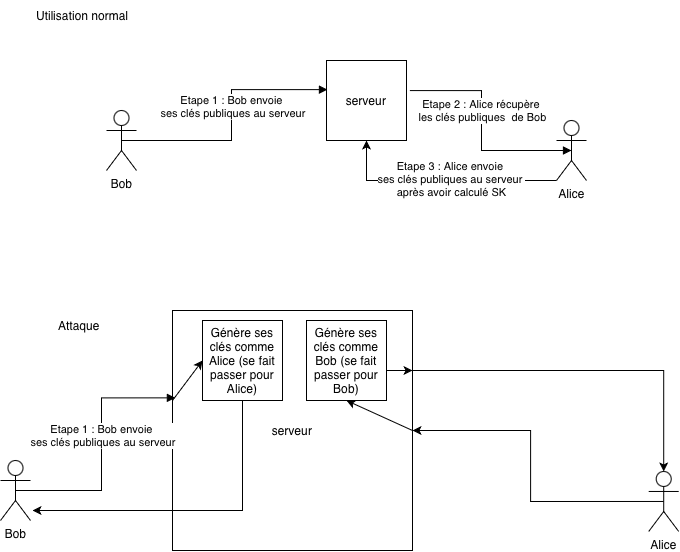

In [8]:
from IPython.display import Image, display

display(Image(filename="MIT.png"))

In [9]:

class serveur():


    def __init__(self):
        self.BOB_PUBLIC_IKB = None,
        self.BOB_PUBLIC_SPKB = None,
        self.BOB_SIGN_SPKB = None,
        self.BOB_PUBLIC_OPKB_pairs = [],
        self.initialmessage = None
        self.tmp = None

        self.destinataire_1 = Bob()
        self.destinataire_1.generation_general()
        self.parameters_from_destinataire_1 = self.destinataire_1.send_bob_parameters()
        self.destinataire_2 = Alice()
        self.destinataire_2.generation_general()
    
    # we collect true bob parameters
    def reception_Bob_parameters(self,values):

        self.tmp = values
        self.BOB_PUBLIC_IKB = self.tmp['PUBLIC_IKB']
        self.BOB_PUBLIC_SPKB = self.tmp['PUBLIC_SPKB']
        self.BOB_SIGN_SPKB = self.tmp['SIGN_SPKB']
        self.BOB_PUBLIC_OPKB_pairs = self.tmp['PUBLIC_OPKB_pairs']
    
    # we send false bob parameters (generate by us)
    def send_bob_parameters(self):
        if self.parameters_from_destinataire_1['PUBLIC_OPKB_pairs']:
            val = self.parameters_from_destinataire_1['PUBLIC_OPKB_pairs'].pop(0)  # retourne et supprime le premier
        else:
            val = None
        return {
            "PUBLIC_IKB": self.parameters_from_destinataire_1['PUBLIC_IKB'],
            "PUBLIC_SPKB": self.parameters_from_destinataire_1['PUBLIC_SPKB'],
            "SIGN_SPKB": self.parameters_from_destinataire_1['SIGN_SPKB'],
            "PUBLIC_OPKB": val
        }
    
    # Compute the secret between true Alice and false Bob
    def setInitialmessageAlice(self,m):
        self.initialmessage = m
        message = self.destinataire_1.messagefromAlice(m)
        print

    # send at the true Bob the messsage from the false Alice
    # Allow to Compute the secret between false Alice and true Bob
    def getInitialmessageAlice(self):
        if self.tmp['PUBLIC_OPKB_pairs']:
            val = self.tmp['PUBLIC_OPKB_pairs'].pop(0)
        else:
            val = None
        first_message = self.destinataire_2.reception_Bob_parameters({
            "PUBLIC_IKB": self.tmp['PUBLIC_IKB'],
            "PUBLIC_SPKB": self.tmp['PUBLIC_SPKB'],
            "SIGN_SPKB": self.tmp['SIGN_SPKB'],
            "PUBLIC_OPKB": val})
        return first_message



def X3DH(params): #algorithm has three phases:
    # 1. Bob publishes his identity key and prekeys to a server.

    # Generation from Bob
    User_Bob = Bob()
    User_Bob.generation_general()
    parameters_from_bob = User_Bob.send_bob_parameters()
    # Reception by serveur
    User_serveur = serveur()
    User_serveur.reception_Bob_parameters(parameters_from_bob)

    # 2. Alice fetches a “prekey bundle” from the server, and uses it to send an
    # initial message to Bob.
    User_Alice = Alice()
    User_Alice.generation_general()
    first_message = User_Alice.reception_Bob_parameters(User_serveur.send_bob_parameters())
    User_serveur.setInitialmessageAlice(first_message)
    
    # 3. Bob receives and processes Alice’s initial message.
    message = User_Bob.messagefromAlice(User_serveur.getInitialmessageAlice())

    print("Secret key de Alice :")
    print(User_Alice.get_sk())
    print("Secret key de Bob :")
    print(User_Bob.get_sk())



SK = X3DH(0)




Secret key de Alice :
b'\x87ME/ud\x06iI\xe8x\x02\xfe\xeb\xfc\xa1\xb16\xcbp\xb2\xb9\x9cR\x9e<\x939\xaal!\xf3'
Secret key de Bob :
b'\xbc\tb\xa5\x98!D\x8ah\xe0,\x1e$F&\xc8\x8f\xc1\xa5J\x94"\xa4p\xb8\xa3\x8c\xb7\xf8x{\x17'


Cette attaque est complétement fonctionnel, le serveur peut tout lire, tout modifier. Il a le controle totale sur la conversation Signal.

En effet, le serveur possède une SK partagé avec Alice, et une autre SK partagé avec Bob.

Notons que le code de X3DH() n'a absolument pas changé. C'est le serveur qui joue entièrement le rôle de l'attaquant.

### Attaque 2 : Un attaquant récupère une ck

In [10]:
class Alice1():
    # Alice is ready to start the first Symmetric ratchet : rk and ck -> ready
    def RatchetInitAlice(self, SK, bob_dh_public_key):
        self.DHs = GENERATE_DH() # DH Ratchet key pair
        self.DHr = bob_dh_public_key # DH Ratchet public key
        self.RK, self.CKs = KDF_RK(SK, DH(self.DHs, self.DHr)) # 32-byte Root Key, 32-byte Chain Keys sending
        self.CKr = None # 32-byte Chain Keys receiving
        self.Ns = 0 # Message numbers for sending
        self.Nr = 0 # Message numbers for receiving
        self.PN = 0 # Number of messages in previous sending chain
        self.MKSKIPPED = {} # Dictionary of skipped-over message keys, indexed by ratchet public key and message number. Raises an exception if too many elements are stored.

    def RatchetSendKey(self):
        # We generate a Ck (to build our ratchet symetrique chain) and a MK (to allow the encryption of a messsage)
        self.CKs, mk = KDF_CK(self.CKs)
        Ns = self.Ns
        self.Ns += 1
        return Ns, mk


    def RatchetEncrypt(self, plaintext):
        AD = b"AD"
        # generate Ck and Mk (a step in the symetrique chain)
        Ns, mk = self.RatchetSendKey()
        # Build a HEADER which contains the public key to build the keys for the symetrique chain, and the numbers of messages 
        header = HEADER(self.DHs, self.PN, Ns)
        # return header and (cyphertext,MAC of header + ciphertext) 
        return header, ENCRYPT(mk, plaintext, CONCAT(AD, header))

    def RatchetReceiveKey(self, header):
        mk = self.TrySkippedMessageKeys(header)
        # mk knows in the database
        if mk != None:
            return mk
        if self.DHr is not None:
            Dhr = self.DHr.public_bytes(
                encoding=serialization.Encoding.Raw,
                format=serialization.PublicFormat.Raw
            )
        else:
            Dhr = None
        
        if Dhr is None or header["DH"] != Dhr:
            # We create the database which contains the mk to encrypt the messages of a symetrique chain
            self.SkipMessageKeys(header["pn"])
            self.DHRatchet(header)
        # We create the database which contains the mk to encrypt the messages of a symetrique chain
        self.SkipMessageKeys(header["n"])
        self.CKr, mk = KDF_CK(self.CKr)
        self.Nr += 1
        return mk
    

    def RatchetDecrypt(self, header, ciphertext):
        AD = b"AD"
        mk = self.RatchetReceiveKey(header)
        return DECRYPT(mk, ciphertext, CONCAT(AD, header))

    def TrySkippedMessageKeys(self, header): 
        if (header["DH"], header["n"]) in self.MKSKIPPED:
            mk = self.MKSKIPPED[header["DH"], header["n"]]
            del self.MKSKIPPED[header["DH"], header["n"]]
            return mk
        else:
            return None

    def SkipMessageKeys(self, until):
        if self.Nr + MAX_SKIP < until:
            raise ValueError()
        if self.CKr != None:
            while self.Nr < until:
                # We create the database (MKSKIPPED) which contains the mk to encrypt the messages of a symetrique chain
                # For example if I want see message number 3, I stock the keys to message 1 and 2 in the database. 
                self.CKr, mk = KDF_CK(self.CKr)
                dh_public = self.DHr.public_bytes(
                    encoding=serialization.Encoding.Raw,
                    format=serialization.PublicFormat.Raw
                )
                self.MKSKIPPED[dh_public, self.Nr] = mk
                self.Nr += 1

    # Génération des valeurs utiles pour le ratchet symétrique 
    def DHRatchet(self, header):
        self.PN = self.Ns
        self.Ns = 0
        self.Nr = 0
        self.DHr = x25519.X25519PublicKey.from_public_bytes(header["DH"])
        self.RK, self.CKr = KDF_RK(self.RK, DH(self.DHs, self.DHr))
        self.DHs = GENERATE_DH()
        self.RK, self.CKs = KDF_RK(self.RK, DH(self.DHs, self.DHr))

class Bob1():
    # Bob is not ready to start the first Symmetric ratchet : rk and ck -> not ready
    # Bob must wait for a first message from Alice
    def RatchetInitBob(self, SK, bob_dh_key_pair):
        self.DHs = bob_dh_key_pair
        self.DHr = None
        self.RK = SK
        self.CKs = None
        self.CKr = None
        self.Ns = 0
        self.Nr = 0
        self.PN = 0
        self.MKSKIPPED = {}


    def RatchetSendKey(self):
            self.CKs, mk = KDF_CK(self.CKs)
            Ns = self.Ns
            self.Ns += 1
            return Ns, mk

    def RatchetEncrypt(self, plaintext,attaque):
        AD = b"AD"
        Ns, mk = self.RatchetSendKey()
        header = HEADER(self.DHs, self.PN, Ns)
        if attaque == 1:
            return header, ENCRYPT(mk, plaintext, CONCAT(AD, header)), self.CKs
        else:
            return header, ENCRYPT(mk, plaintext, CONCAT(AD, header))


    def RatchetReceiveKey(self, header):
        mk = self.TrySkippedMessageKeys(header)
        # 
        if mk != None:
            return mk        

        if self.DHr is not None:
            Dhr = self.DHr.public_bytes(
                encoding=serialization.Encoding.Raw,
                format=serialization.PublicFormat.Raw
            )
        else:
            Dhr = None
        
        if Dhr is None or header["DH"] != Dhr:
            self.SkipMessageKeys(header["pn"])
            self.DHRatchet(header)
        self.SkipMessageKeys(header["n"])
        self.CKr, mk = KDF_CK(self.CKr)
        self.Nr += 1
        return mk
    
    # Bob wants read a message from Alice
    def RatchetDecrypt(self, header, ciphertext):
        AD = b"AD"
        mk = self.RatchetReceiveKey(header)
        return DECRYPT(mk, ciphertext, CONCAT(AD, header))

    def TrySkippedMessageKeys(self, header):
        if (header["DH"], header["n"]) in self.MKSKIPPED:
            mk = self.MKSKIPPED[header["DH"], header["n"]]
            del self.MKSKIPPED[header["DH"], header["n"]]
            return mk
        else:
            return None

    def SkipMessageKeys(self, until):
        if self.Nr + MAX_SKIP < until:
            raise ValueError()
        if self.CKr != None:
            while self.Nr < until:
                self.CKr, mk = KDF_CK(self.CKr)

                dh_public = self.DHr.public_bytes(
                    encoding=serialization.Encoding.Raw,
                    format=serialization.PublicFormat.Raw
                )
                self.MKSKIPPED[dh_public, self.Nr] = mk
                self.Nr += 1
                
    def DHRatchet(self, header):
        self.PN = self.Ns
        self.Ns = 0
        self.Nr = 0
        self.DHr = x25519.X25519PublicKey.from_public_bytes(header["DH"])
        self.RK, self.CKr = KDF_RK(self.RK, DH(self.DHs, self.DHr))
        self.DHs = GENERATE_DH()
        self.RK, self.CKs = KDF_RK(self.RK, DH(self.DHs, self.DHr))

In [11]:
# WARNING : Alice must send in first a message to bob 

# 1. Once Alice and Bob have agreed on SK and Bob’s ratchet public key
# -> Do X3DH -> That gives a SK for the both
secret_key = SK
Bob_ratchet_private_key = curveExchange.X25519PrivateKey.generate()
Bob_ratchet_public_key = Bob_ratchet_private_key.public_key()
Bob_ratchet_key_pair = (Bob_ratchet_private_key, Bob_ratchet_public_key)

# 2. Alice calls RatchetInitAlice() and Bob calls RatchetInitBob():
Alice_ = Alice1()
Bob_ = Bob1()
Serveur_ = Serveur1()

Alice_.RatchetInitAlice(secret_key,Bob_ratchet_public_key)
Bob_.RatchetInitBob(secret_key,Bob_ratchet_key_pair)


print("Exemple de conversation chiffré par signal.\n")

# 3. Alice send message to bob :
Serveur_.receptionAlice(*Alice_.RatchetEncrypt("Salut Bob ! 😀".encode('utf-8')))
Serveur_.receptionAlice(*Alice_.RatchetEncrypt("Comment vas-tu depuis tout ce temps ? 😇".encode('utf-8')))


print("Alice :")

print(Bob_.RatchetDecrypt(*Serveur_.sendtoBob()).decode('utf-8'))
print(Bob_.RatchetDecrypt(*Serveur_.sendtoBob()).decode('utf-8'))

#### ATTAQUE ICI !!!!! ####
# CK fuite ici 
Chaine_attaquant = [] # l'attaquant peut lire en toute légitimité le header et le ciphertext.
header, ciphertext, ck = Bob_.RatchetEncrypt("Salut Alice ! Tout vas bien pour moi !".encode('utf-8'),1)
Serveur_.receptionBob(header, ciphertext)
header, ciphertext = Bob_.RatchetEncrypt("Et toi ? Tu es diplomé désormais ? :)".encode('utf-8'),0)
Chaine_attaquant.append([header, ciphertext])
Serveur_.receptionBob(header, ciphertext)
header, ciphertext = Bob_.RatchetEncrypt("En fait, j'ai oublié de te dire hier !".encode('utf-8'),0)
Chaine_attaquant.append([header, ciphertext])
Serveur_.receptionBob(header, ciphertext)
header, ciphertext = Bob_.RatchetEncrypt("Je t'ai vu, tu marchais seule près du parc.".encode('utf-8'),0)
Chaine_attaquant.append([header, ciphertext])
Serveur_.receptionBob(header, ciphertext)


print("Bob :")
print(Alice_.RatchetDecrypt(*Serveur_.sendtoAlice()).decode('utf-8'))
print(Alice_.RatchetDecrypt(*Serveur_.sendtoAlice()).decode('utf-8'))
print(Alice_.RatchetDecrypt(*Serveur_.sendtoAlice()).decode('utf-8'))
print(Alice_.RatchetDecrypt(*Serveur_.sendtoAlice()).decode('utf-8'))

print("Alice :")
Serveur_.receptionAlice(*Alice_.RatchetEncrypt("Oui je viens d'avoir mon master ! 🥳".encode('utf-8')))
print(Bob_.RatchetDecrypt(*Serveur_.sendtoBob()).decode('utf-8'))

Exemple de conversation chiffré par signal.

Alice :
Salut Bob ! 😀
Comment vas-tu depuis tout ce temps ? 😇
Bob :
Salut Alice ! Tout vas bien pour moi !
Et toi ? Tu es diplomé désormais ? :)
En fait, j'ai oublié de te dire hier !
Je t'ai vu, tu marchais seule près du parc.
Alice :
Oui je viens d'avoir mon master ! 🥳


L'attaquant peut lire tous les messages de la chaîne en ayant accès au ck

In [12]:
class AttackerChain:
    def __init__(self, compromised_ck, start_n=0):
        self.CK = compromised_ck
        self.n = start_n

    def next_mk(self):
        self.CK, mk = KDF_CK(self.CK)
        self.n += 1
        return mk

    def decrypt_next(self, header, ciphertext):
        AD = b"AD"
        mk = self.next_mk()
        return DECRYPT(mk, ciphertext, CONCAT(AD, header))
    

print("Messages récupéré par l'atatquant :\n")
attacker = AttackerChain(ck)
for header, ciphertext in Chaine_attaquant:
    # print(header, ciphertext)
    plaintext = attacker.decrypt_next(header, ciphertext)
    print(plaintext.decode('utf-8'))

Messages récupéré par l'atatquant :

Et toi ? Tu es diplomé désormais ? :)
En fait, j'ai oublié de te dire hier !
Je t'ai vu, tu marchais seule près du parc.


# A faire :

- Relire les deux documents pour vérifier que les parametres crypto sont ok (AD aussi, le changer a chaque fois ????) -> pas nécessaire pour l'exo de faire le vrai clé schedule
- Key schedule (gestion des clés, savoir quand on doit les supprimer) -> pas nécessaire

Plus tard : 

- Le faire dans un environnement ou docker pour l'user 
- Faire un jeu de test et exemple d'utilisation
- Faire un readme
